In [5]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [6]:
from king_windy_gridworld_env import KingWindyGridWorldEnv
from stoch_king_windy_gridworld_env import StochKingWindyGridWorldEnv
from stoch_windy_gridworld_env import StochWindyGridWorldEnv
from windy_gridworld_env import WindyGridWorldEnv

In [13]:
env_kwg = KingWindyGridWorldEnv()
env_skwg = StochKingWindyGridWorldEnv()
env_swg = StochWindyGridWorldEnv()
env_wg = WindyGridWorldEnv()

In [14]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [15]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn

100%|██████████| 100/100 [00:00<00:00, 388.72it/s]


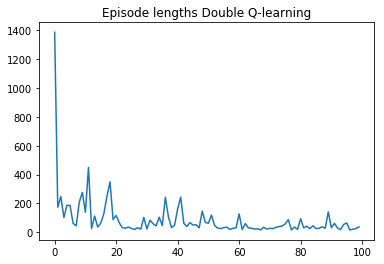

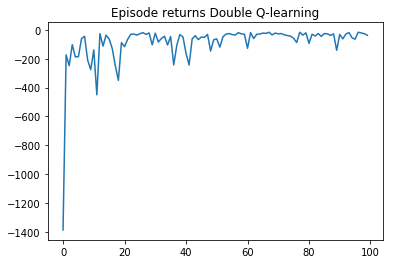

In [16]:
def double_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.05):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q1_sum_Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q1_sum_Q2, epsilon, env.action_space.n)

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            new_s, r, done, _ = env.step(a)
            R += r
            coin_toss = random.randint(0, 1)
            if (coin_toss == 0):
              Q1[s][a] = Q1[s][a] + alpha * (r + discount_factor * Q2[new_s][np.argmax(Q1[new_s])] - Q1[s][a]) if not done else Q1[s][a] + alpha * (r - Q1[s][a])
            else:
              Q2[s][a] = Q2[s][a] + alpha * (r + discount_factor * Q1[new_s][np.argmax(Q2[new_s])] - Q2[s][a]) if not done else Q2[s][a] + alpha * (r - Q2[s][a])
              
            #Q1_sum_Q2[s][a] = np.maximum(Q1[s][a], Q2[s][a])
            #print(Q1[s][a])
            #print(Q2[s][a])
            #print(np.maximum(Q1[s][a], Q2[s][a]))
            Q1_sum_Q2[s][a] = Q1[s][a]+ Q2[s][a]
            s = new_s
            i += 1
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q1, (episode_lengths, episode_returns)

Double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, 100)

# We will help you with plotting this time
plt.plot(episode_lengths_double_q_learning)
plt.title('Episode lengths Double Q-learning')
plt.show()
plt.plot(episode_returns_double_q_learning)
plt.title('Episode returns Double Q-learning')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 562.27it/s]


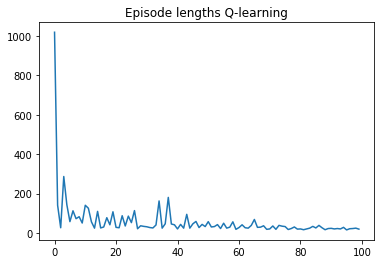

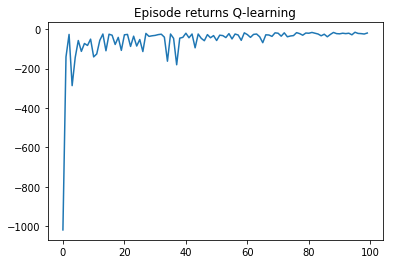

In [18]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.05, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            new_s, r, done, _ = env.step(a)
            R += r
            Q[s][a] = Q[s][a] + alpha * (r + discount_factor * np.max(Q[new_s]) - Q[s][a]) if not done else Q[s][a] + alpha * (r - Q[s][a])
            s = new_s
            i += 1
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 100)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

In [30]:
def sample_returns(env, policy):
    R = 0
    s = env.reset()
    done = False
    i = 0
    while not done:
        i+=1
        if i>1000:
            print("Infinite loop")
            raise Exception("Infinite loop")
        a = policy(s)
        new_situation = env.step(a)
        R += new_situation[1]
        done = new_situation[2]
        s = new_situation[0]
    return R

def estimate_stoch_policy(env, policy, K):
    returns = []
    for k in range(K):
        returns.append(sample_returns(env, policy))
    return returns

In [34]:
def learn_policy(env, episodes):
    Q_double_q_learning, _ = double_q_learning(env, episodes)
    Q_q_learning, _ = q_learning(env, episodes)
    policy_double_q_learning =  make_epsilon_greedy_policy(Q_double_q_learning, 0, env.action_space.n)
    policy_q_learning = make_epsilon_greedy_policy(Q_q_learning, 0, env.action_space.n)
    
    return {'policy_double_q':policy_double_q_learning, 'policy_q':policy_q_learning}

def learn_estimate(env, episodes, runs, K):
    double_q_learning_returns, Q_learning_returns = [], []
    for i in range(runs):
        np.random.seed(i)
        policy_dict = learn_policy(env, episodes)
        try:
            #print('hi')
            Q_learning_return = estimate_stoch_policy(env, policy_dict['policy_q'], K)
            double_q_learning_return = estimate_stoch_policy(env, policy_dict['policy_double_q'], K)
        except:
            #print('bye')
            continue
        Q_learning_returns.append(Q_learning_return)
        double_q_learning_returns.append(double_q_learning_return)
        print('Mean:  q = ', np.mean(Q_learning_returns), ' double q = ', np.mean(double_q_learning_returns))
    return {'returns_q':Q_learning_returns, 'returns_double_q':double_q_learning_returns}

In [38]:
def stat_test(returns_dict):
    mean_returns = {}
    mean_returns['q'] = [np.mean(returns) for returns in returns_dict['returns_q']]
    mean_returns['double_q'] = [np.mean(returns) for returns in returns_dict['returns_double_q']]
    from scipy.stats import ttest_ind
    print("The result from an independent t-test are as follows.")
    print(ttest_ind(mean_returns['double_q'], mean_returns['q']))
    print('Mean returns ')
    print('Q-learning ', np.mean(mean_returns['q']))
    print('Double Q-learning ', np.mean(mean_returns['double_q']))

# Experiments

# Stochastic windy gridworld 

## episodes = 2000

  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -18.1  double q =  -19.7


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -19.35  double q =  -20.75


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -18.4  double q =  -20.533333333333335


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -19.925  double q =  -20.275


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -19.72  double q =  -21.96


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.366666666666667  double q =  -21.416666666666668


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.314285714285713  double q =  -21.714285714285715


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.9875  double q =  -27.8625


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.8  double q =  -26.655555555555555


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.82  double q =  -25.91


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.736363636363638  double q =  -25.363636363636363


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.5  double q =  -24.716666666666665


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.353846153846153  double q =  -24.6


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.435714285714287  double q =  -24.25


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.293333333333333  double q =  -24.66


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -20.8  double q =  -24.45625


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.188235294117646  double q =  -24.294117647058822


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.27777777777778  double q =  -24.227777777777778


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.521052631578947  double q =  -25.568421052631578


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.53  double q =  -25.195


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.461904761904762  double q =  -24.966666666666665


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.536363636363635  double q =  -24.818181818181817


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.51304347826087  double q =  -24.752173913043478


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -21.295833333333334  double q =  -24.441666666666666


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


100%|██████████| 2000/2000 [00:05<00:00, 386.95it/s]


Infinite loop
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-1.2277453082255703, pvalue=0.225788253688193)
Mean returns 
Q-learning  -21.295833333333334
Double Q-learning  -24.441666666666663


Text(0, 0.5, 'Number of runs')

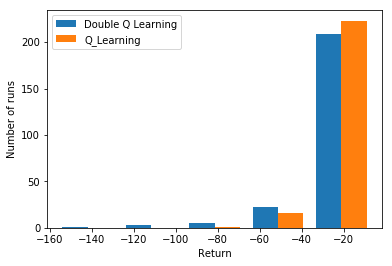

In [86]:
episodes = 2000
runs = 60
K = 10

returns_dict = learn_estimate(env_swg, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

## episodes = 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -23.6  double q =  -22.8


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -19.75  double q =  -26.65


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -23.266666666666666  double q =  -24.533333333333335


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -24.425  double q =  -22.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -23.46  double q =  -22.14


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -25.283333333333335  double q =  -21.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -24.685714285714287  double q =  -21.32857142857143


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -23.9625  double q =  -21.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -24.1  double q =  -21.988888888888887


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -23.83  double q =  -22.04


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -23.336363636363636  double q =  -21.8


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.958333333333332  double q =  -22.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -23.03846153846154  double q =  -21.73846153846154


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.757142857142856  double q =  -21.985714285714284


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.786666666666665  double q =  -22.033333333333335


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.75  double q =  -21.96875


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.805882352941175  double q =  -21.958823529411763


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.761111111111113  double q =  -21.905555555555555


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.563157894736843  double q =  -21.98421052631579


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.67  double q =  -21.945


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.604761904761904  double q =  -21.776190476190475


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -22.168181818181818  double q =  -21.65909090909091


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -21.87391304347826  double q =  -21.743478260869566


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -21.708333333333332  double q =  -21.795833333333334


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -21.692  double q =  -21.872


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -21.873076923076923  double q =  -21.78846153846154


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -21.896296296296295  double q =  -21.803703703703704


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -21.925  double q =  -21.764285714285716


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


100%|██████████| 1000/1000 [00:04<00:00, 207.79it/s]

Mean:  q =  -21.851724137931033  double q =  -21.879310344827587
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-0.026869746225760317, pvalue=0.9786591494096879)
Mean returns 
Q-learning  -21.851724137931033
Double Q-learning  -21.879310344827594


Text(0, 0.5, 'Number of runs')

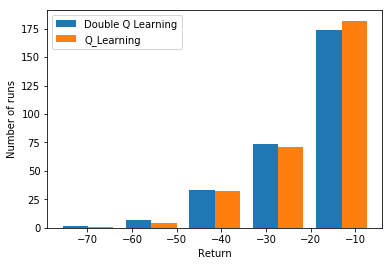

In [41]:
episodes = 1000
runs = 60
K = 10

returns_dict = learn_estimate(env_swg, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

## episodes = 500

  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -33.1  double q =  -41.2


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -27.15  double q =  -30.0


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -25.6  double q =  -29.4


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -26.075  double q =  -27.325


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -23.96  double q =  -25.82


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -22.316666666666666  double q =  -26.3


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.7  double q =  -28.771428571428572


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.6375  double q =  -28.0875


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.711111111111112  double q =  -27.066666666666666


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.49  double q =  -27.13


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.245454545454546  double q =  -26.736363636363638


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -20.783333333333335  double q =  -26.45


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.00769230769231  double q =  -26.415384615384614


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.335714285714285  double q =  -26.5


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.526666666666667  double q =  -26.086666666666666


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.45  double q =  -26.325


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.141176470588235  double q =  -26.011764705882353


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -21.25  double q =  -25.705555555555556


100%|██████████| 500/500 [00:01<00:00, 294.62it/s]

Infinite loop
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-2.2227763064608856, pvalue=0.03298487972751764)
Mean returns 
Q-learning  -21.250000000000004
Double Q-learning  -25.705555555555556


Text(0, 0.5, 'Number of runs')

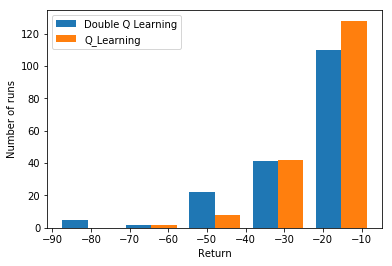

In [87]:
episodes = 500
runs = 60
K = 10

returns_dict = learn_estimate(env_swg, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

# Roullete

## episodes = 2000

  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.4  double q =  40.6


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.9  double q =  1.75


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.1333333333333333  double q =  0.36666666666666664


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -0.25  double q =  0.775


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -0.56  double q =  -0.14


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.1666666666666667  double q =  -0.48333333333333334


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -0.9428571428571428  double q =  0.07142857142857142


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.2  double q =  -0.2125


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.288888888888889  double q =  0.05555555555555555


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.22  double q =  -0.39


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.0727272727272728  double q =  -0.42727272727272725


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.4333333333333333  double q =  -0.6916666666666667


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.1076923076923078  double q =  -0.9


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.4142857142857144  double q =  -0.9214285714285714


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.4533333333333334  double q =  -1.22


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.5375  double q =  -0.84375


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.7529411764705882  double q =  -1.311764705882353


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.1444444444444444  double q =  -1.2166666666666666


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -1.9894736842105263  double q =  -1.236842105263158


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.31  double q =  -1.265


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.4095238095238094  double q =  -1.3952380952380952


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.5272727272727273  double q =  -1.5863636363636364


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.417391304347826  double q =  -1.5956521739130434


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.466666666666667  double q =  -1.5958333333333334


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.672  double q =  -1.732


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.4615384615384617  double q =  -1.95


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.585185185185185  double q =  -1.862962962962963


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.55  double q =  -1.8107142857142857


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -2.475862068965517  double q =  -1.8172413793103448


100%|██████████| 2000/2000 [00:03<00:00, 535.44it/s]

Mean:  q =  -2.56  double q =  -1.77
The result from an independent t-test are as follows.
Ttest_indResult(statistic=0.3889244101084041, pvalue=0.6987562536367494)
Mean returns 
Q-learning  -2.56
Double Q-learning  -1.77


Text(0, 0.5, 'Number of runs')

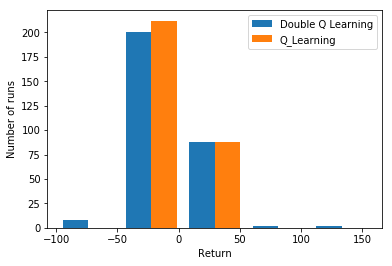

In [60]:
import gym
env_lake = gym.make("FrozenLake-v0", is_slippery=True, map_name='8x8')
env_rou = gym.make('Roulette-v0')

episodes = 2000
runs = 30
K = 10

returns_dict = learn_estimate(env_rou, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

## episodes = 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  1.4  double q =  0.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -8.6  double q =  -1.3


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -7.066666666666666  double q =  -2.4


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -6.75  double q =  -0.7


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -5.08  double q =  -0.04


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -4.4  double q =  -0.8333333333333334


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -4.228571428571429  double q =  -1.457142857142857


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -3.825  double q =  -2.15


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -4.155555555555556  double q =  -1.8888888888888888


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -3.56  double q =  -2.08


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -3.290909090909091  double q =  -2.2363636363636363


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.9  double q =  -2.1333333333333333


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.707692307692308  double q =  -2.046153846153846


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.8285714285714287  double q =  -2.6142857142857143


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.4266666666666667  double q =  -2.84


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.2875  double q =  -3.1125


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.1411764705882352  double q =  -3.2941176470588234


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.1  double q =  -3.088888888888889


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.1894736842105265  double q =  -3.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.33  double q =  -3.09


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.5619047619047617  double q =  -3.3047619047619046


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.5454545454545454  double q =  -3.3363636363636364


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.582608695652174  double q =  -3.2869565217391306


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.65  double q =  -3.225


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.912  double q =  -3.248


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.7384615384615385  double q =  -3.1384615384615384


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.6222222222222222  double q =  -3.1703703703703705


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.4714285714285715  double q =  -3.2714285714285714


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.510344827586207  double q =  -3.179310344827586


100%|██████████| 1000/1000 [00:01<00:00, 544.57it/s]

Mean:  q =  -2.6333333333333333  double q =  -3.24
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-0.6126539230859017, pvalue=0.5424999635826939)
Mean returns 
Q-learning  -2.6333333333333333
Double Q-learning  -3.24


Text(0, 0.5, 'Number of runs')

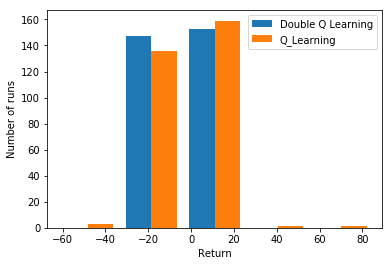

In [83]:
#env_lake = gym.make("FrozenLake-v0", is_slippery=True, map_name='8x8')
env_rou = gym.make('Roulette-v0')

episodes = 1000
runs = 30
K = 10

returns_dict = learn_estimate(env_rou, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

## episodes = 500

  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -5.6  double q =  -5.2


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -5.0  double q =  -2.2


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.1333333333333333  double q =  -2.6


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.6  double q =  -1.95
Mean:  q =  -2.88  double q =  -1.24


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.533333333333333  double q =  -1.0333333333333334


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.8  double q =  -1.542857142857143


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.9  double q =  -1.95


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.8666666666666667  double q =  -1.8222222222222222


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.94  double q =  -1.72


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.0  double q =  -1.2545454545454546


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.7333333333333334  double q =  -1.15


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.6615384615384614  double q =  -1.0461538461538462


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.5142857142857142  double q =  -0.9142857142857143


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.453333333333333  double q =  -1.28


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.4875  double q =  -1.1375


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.788235294117647  double q =  -0.8705882352941177


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -3.7222222222222223  double q =  -0.7888888888888889


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.7  double q =  -0.8631578947368421


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.775  double q =  -1.05


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.804761904761905  double q =  -1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.659090909090909  double q =  -1.1
Mean:  q =  -4.456521739130435  double q =  -1.208695652173913


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.495833333333334  double q =  -1.35


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.42  double q =  -1.528


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.226923076923077  double q =  -1.6153846153846154


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.018518518518518  double q =  -1.5555555555555556
Mean:  q =  -3.875  double q =  -1.707142857142857


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -4.510344827586207  double q =  -1.5862068965517242


100%|██████████| 500/500 [00:01<00:00, 413.35it/s]

Mean:  q =  -4.513333333333334  double q =  -1.4666666666666666
The result from an independent t-test are as follows.
Ttest_indResult(statistic=2.704996164525199, pvalue=0.008951958697415233)
Mean returns 
Q-learning  -4.513333333333333
Double Q-learning  -1.4666666666666666


Text(0, 0.5, 'Number of runs')

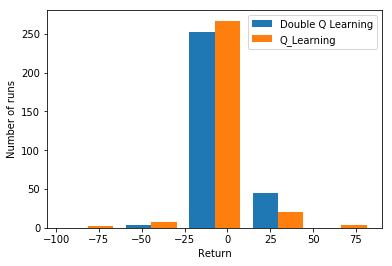

In [62]:
import gym
env_lake = gym.make("FrozenLake-v0", is_slippery=True, map_name='8x8')
env_rou = gym.make('Roulette-v0')

episodes = 500
runs = 30
K = 10

returns_dict = learn_estimate(env_rou, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

# Stochastic king windy gridworld

## episodes = 2000

  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -12.2  double q =  -14.3


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -11.35  double q =  -14.5


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -11.5  double q =  -13.266666666666667


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -11.7  double q =  -14.55


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -11.92  double q =  -13.54


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -12.016666666666667  double q =  -13.75


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -12.642857142857142  double q =  -13.742857142857142


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.95  double q =  -13.45


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.9  double q =  -14.444444444444445


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.59  double q =  -14.02


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.372727272727273  double q =  -14.527272727272727


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.408333333333333  double q =  -15.225


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.584615384615384  double q =  -15.161538461538461


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.75  double q =  -16.014285714285716


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -13.773333333333333  double q =  -15.66


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -14.00625  double q =  -16.0375


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean:  q =  -14.629411764705882  double q =  -16.08235294117647


100%|██████████| 2000/2000 [00:05<00:00, 387.75it/s]


Mean:  q =  -15.172222222222222  double q =  -15.86111111111111
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-0.4279470474157158, pvalue=0.6713883182468586)
Mean returns 
Q-learning  -15.17222222222222
Double Q-learning  -15.861111111111114


Text(0, 0.5, 'Number of runs')

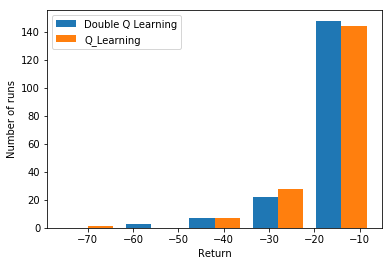

In [66]:
episodes = 2000
runs = 30
K = 10

returns_dict = learn_estimate(env_skwg, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

## episodes = 1000

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -27.1  double q =  -13.4


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -18.55  double q =  -16.9


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -15.6  double q =  -16.3


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -15.625  double q =  -17.7


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.94  double q =  -17.56


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.8  double q =  -18.033333333333335


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.557142857142857  double q =  -16.914285714285715


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.3625  double q =  -17.4375


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.366666666666667  double q =  -18.211111111111112


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.52  double q =  -17.61


  0%|          | 0/1000 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.89090909090909  double q =  -17.181818181818183


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -14.525  double q =  -17.433333333333334


100%|██████████| 1000/1000 [00:04<00:00, 233.10it/s]

Mean:  q =  -14.707692307692307  double q =  -18.130769230769232
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-1.809351751604734, pvalue=0.08293995182727064)
Mean returns 
Q-learning  -14.707692307692309
Double Q-learning  -18.13076923076923


Text(0, 0.5, 'Number of runs')

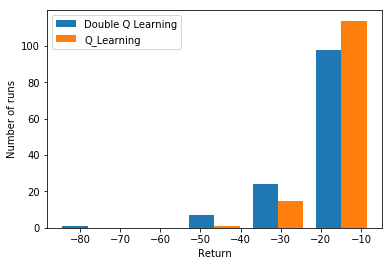

In [84]:
episodes = 1000
runs = 30
K = 10

returns_dict = learn_estimate(env_skwg, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

## episodes = 500

  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -17.9  double q =  -22.0


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -14.45  double q =  -23.35


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -17.066666666666666  double q =  -24.233333333333334


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -20.975  double q =  -21.925


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -20.9  double q =  -22.16


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -19.116666666666667  double q =  -22.25


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -18.0  double q =  -21.1


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -17.1125  double q =  -20.8375


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -16.844444444444445  double q =  -23.68888888888889


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Infinite loop


  0%|          | 0/500 [00:00<?, ?it/s]

Mean:  q =  -17.03  double q =  -23.5


100%|██████████| 500/500 [00:03<00:00, 135.20it/s]

Mean:  q =  -16.60909090909091  double q =  -23.136363636363637
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-1.9728506095621863, pvalue=0.062495493204451344)
Mean returns 
Q-learning  -16.60909090909091
Double Q-learning  -23.136363636363637


Text(0, 0.5, 'Number of runs')

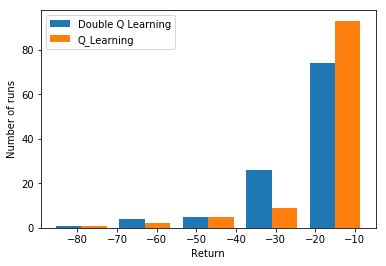

In [85]:
episodes = 500
runs = 30
K = 10

returns_dict = learn_estimate(env_skwg, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

# draft

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -11.4  double q =  -856.6


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -12.5  double q =  -624.65


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -5.466666666666667  double q =  -515.3


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.0  double q =  -635.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  0.14  double q =  -590.92


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  1.5833333333333333  double q =  -571.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -0.35714285714285715  double q =  -551.9285714285714


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  0.875  double q =  -542.5375


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -0.6333333333333333  double q =  -525.7888888888889


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  0.18  double q =  -472.24


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  0.9181818181818182  double q =  -432.27272727272725


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -0.25  double q =  -482.68333333333334


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  0.34615384615384615  double q =  -463.5923076923077


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  0.9857142857142858  double q =  -461.4


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  1.44  double q =  -458.1533333333333


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  1.79375  double q =  -444.15


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  0.9705882352941176  double q =  -443.5705882352941


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -0.9333333333333333  double q =  -441.9


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -1.4842105263157894  double q =  -450.9263157894737


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.025  double q =  -461.2


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -1.4904761904761905  double q =  -467.54285714285714


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -1.9636363636363636  double q =  -466.0409090909091


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.4782608695652173  double q =  -474.30434782608694


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -2.0375  double q =  -471.7708333333333


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -1.556  double q =  -461.408


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -1.9846153846153847  double q =  -458.7692307692308


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -1.5888888888888888  double q =  -463.73333333333335


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -1.2785714285714285  double q =  -461.89285714285717


  0%|          | 0/1000 [00:00<?, ?it/s]

Mean:  q =  -0.9517241379310345  double q =  -473.34137931034485


100%|██████████| 1000/1000 [00:00<00:00, 1071.50it/s]

Mean:  q =  -0.62  double q =  -472.01666666666665
The result from an independent t-test are as follows.
Ttest_indResult(statistic=-10.839740619314405, pvalue=1.4366335596794623e-15)
Mean returns 
Q-learning  -0.6199999999999992
Double Q-learning  -472.01666666666665


Text(0, 0.5, 'Number of runs')

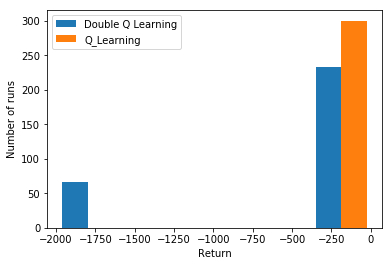

In [75]:
env_hc = gym.make('Taxi-v2')


episodes = 1000
runs = 30
K = 10

returns_dict = learn_estimate(env_hc, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

In [81]:
episodes = 1000
runs = 30
K = 10

env_kf = gym.make('KellyCoinflipGeneralized-v0')

returns_dict = learn_estimate(env_kcf, episodes, runs, K)
stat_test(returns_dict)

returns_double_q =[r for returns in returns_dict['returns_double_q'] for r in returns]
returns_q = [r for returns in returns_dict['returns_q'] for r in returns]

plt.hist([returns_double_q,returns_q], bins=5)
plt.legend(['Double Q Learning', 'Q_Learning'])
plt.xlabel("Return")
plt.ylabel("Number of runs")

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: unhashable type: 'numpy.ndarray'

In [79]:
from gym import envs
envids = [spec.id for spec in envs.registry.all()]
for envid in sorted(envids):
    print(envid)

Acrobot-v1
AirRaid-ram-v0
AirRaid-ram-v4
AirRaid-ramDeterministic-v0
AirRaid-ramDeterministic-v4
AirRaid-ramNoFrameskip-v0
AirRaid-ramNoFrameskip-v4
AirRaid-v0
AirRaid-v4
AirRaidDeterministic-v0
AirRaidDeterministic-v4
AirRaidNoFrameskip-v0
AirRaidNoFrameskip-v4
Alien-ram-v0
Alien-ram-v4
Alien-ramDeterministic-v0
Alien-ramDeterministic-v4
Alien-ramNoFrameskip-v0
Alien-ramNoFrameskip-v4
Alien-v0
Alien-v4
AlienDeterministic-v0
AlienDeterministic-v4
AlienNoFrameskip-v0
AlienNoFrameskip-v4
Amidar-ram-v0
Amidar-ram-v4
Amidar-ramDeterministic-v0
Amidar-ramDeterministic-v4
Amidar-ramNoFrameskip-v0
Amidar-ramNoFrameskip-v4
Amidar-v0
Amidar-v4
AmidarDeterministic-v0
AmidarDeterministic-v4
AmidarNoFrameskip-v0
AmidarNoFrameskip-v4
Ant-v2
Ant-v3
Assault-ram-v0
Assault-ram-v4
Assault-ramDeterministic-v0
Assault-ramDeterministic-v4
Assault-ramNoFrameskip-v0
Assault-ramNoFrameskip-v4
Assault-v0
Assault-v4
AssaultDeterministic-v0
AssaultDeterministic-v4
AssaultNoFrameskip-v0
AssaultNoFrameskip-v4
Ast